# Neural style transfer with Keras

## See Chapter 8.3 Page 280 of Keras Book for tensorflow 1 implementation

## Francois Chollet 2/5/20
## I rewrote the old Keras neural style transfer code example to modern Keras.
## I switched it from using scipy's L-BFGS to vanilla SGD -- the whole thing is 
## just a few lines of pure Keras/TF now.


## Introduction

Style transfer consists in generating an image
with the same "content" as a base image, but with the
"style" of a different picture (typically artistic).
This is achieved through the optimization of a loss function
that has 3 components: "style loss", "content loss",
and "total variation loss":

- Style = textures, colours, visual patterns
- Content = higher level macro structure

- The total variation loss imposes local spatial continuity between
the pixels of the combination image, giving it visual coherence.
- The style loss is where the deep learning keeps in --that one is defined
using a deep convolutional neural network. Precisely, it consists in a sum of
L2 distances between the Gram matrices of the representations of
the base image and the style reference image, extracted from
different layers of a convnet (trained on ImageNet). The general idea
is to capture color/texture information at different spatial
scales (fairly large scales --defined by the depth of the layer considered).
- The content loss is a L2 distance between the features of the base
image (extracted from a deep layer) and the features of the combination image,
keeping the generated image close enough to the original one.

**Reference:** [A Neural Algorithm of Artistic Style](
  http://arxiv.org/abs/1508.06576)

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
#root_dir= os.path.abspath(''); root_dir

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
root_dir = '/content/drive/My Drive/Colab Notebooks/style-transfer/f1car-style-transfer'

In [0]:
import os

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

'''
base_image_path = keras.utils.get_file('paris.jpg', 'https://i.imgur.com/F28w3Ac.jpg')
base_image_path = keras.utils.get_file('paris-tf2.jpg',
                                       'https://i.imgur.com/F28w3Ac.jpg',
                                       cache_subdir=root_dir)


style_reference_image_path = keras.utils.get_file('starry_night.jpg', 'https://i.imgur.com/9ooB60I.jpg')
style_reference_image_path = keras.utils.get_file('starry_night-tf2.jpg', 
                                                  'https://i.imgur.com/9ooB60I.jpg',
                                                  cache_subdir=root_dir)

#REF for parameter checks https://www.tensorflow.org/tutorials/generative/style_transfer
base_image_path= tf.keras.utils.get_file('YellowLabradorLooking_new.jpg',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg',
  cache_subdir=root_dir)
style_reference_image_path= tf.keras.utils.get_file('kandinsky5.jpg',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  cache_subdir=root_dir)
result_prefix = os.path.join(root_dir, 'fromtensorflow-test.jpg')
'''

base_image_path = os.path.join(root_dir, 'renault-hires-1.jpg')
style_reference_image_path = os.path.join(root_dir, 'picasso-1.jpg')

result_prefix = os.path.join(root_dir, 'renault-hires-1-pica1-op')
iterations = 2000

# Weights of the different loss components
#racing point
total_variation_weight = 1e-5 #ren 1e-5 # fchollet 1e-6
style_weight = 1e-5 #ren 1e-5 # fchollet 1e-6
content_weight = 5e-7 #renault 1e-7# fchollet 2.5e-8
#higher means target content more recognisable in generated img

#renault
#total_variation_weight = 1e-5 #ren 1e-5
#style_weight = 1e-5 #ren 1e-5
#content_weight = 5e-7#renault 1e-7#2.5e-8 #higher means target content more recognisable in generated img


# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## Let's take a look at our base (content) image and our style reference image

In [5]:
width, height = keras.preprocessing.image.load_img(base_image_path).size
height

362

In [6]:
tf.__version__
print(base_image_path)
print(style_reference_image_path)

/content/drive/My Drive/Colab Notebooks/style-transfer/f1car-style-transfer/renault-hires-1.jpg
/content/drive/My Drive/Colab Notebooks/style-transfer/f1car-style-transfer/picasso-1.jpg


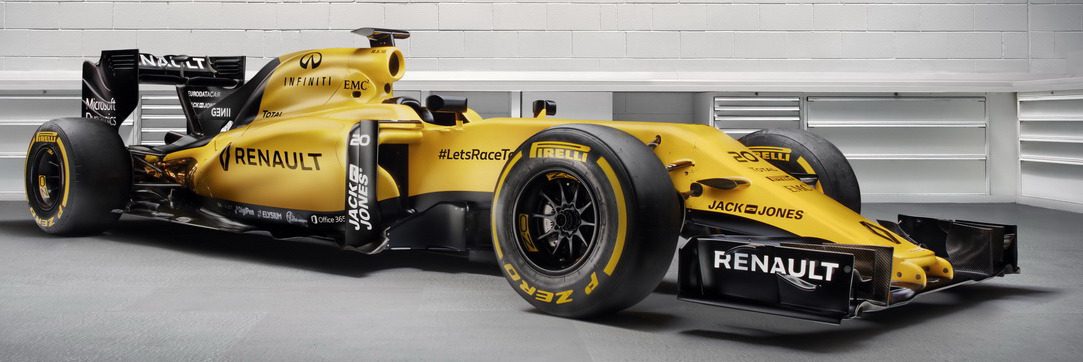

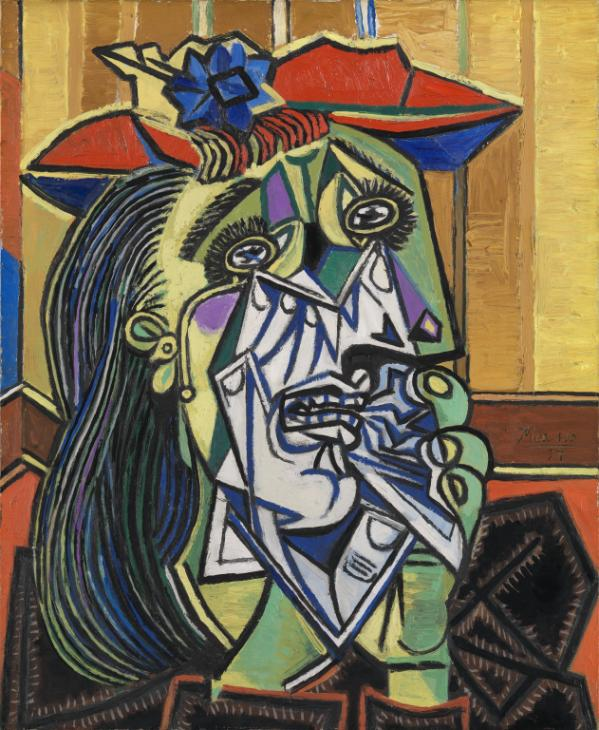

In [7]:
from IPython.display import Image, display
display(Image(base_image_path))
display(Image(style_reference_image_path))

## Image preprocessing / deprocessing utilities

In [0]:
def preprocess_image(image_path):
  # Util function to open, resize and format pictures into appropriate tensors
  img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return tf.convert_to_tensor(img)

def deprocess_image(x):
  # Util function to convert a tensor into a valid image
  x = x.reshape((img_nrows, img_ncols, 3))
  # Remove zero-center by mean pixel
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # 'BGR'->'RGB'
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

## Compute the style transfer loss

First, we need to define 4 utility functions:

- `gram_matrix` (used to compute the style loss)
- The `style_loss` function, which keeps the generated image close to the local textures of the style reference image
- The `content_loss` function, which keeps the high-level representation of the
generated image close to that of the base image
- The `total_variation_loss` function, a regularization loss which keeps the generated image locally-coherent

In [0]:
# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
  x = tf.transpose(x, (2, 0, 1))
  features = tf.reshape(x, (tf.shape(x)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))
  return gram

# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_nrows * img_ncols
  return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image

def content_loss(base, combination):
  return tf.reduce_sum(tf.square(combination - base))

# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

def total_variation_loss(x):
  a = tf.square(
      x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
  b = tf.square(
      x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
  return tf.reduce_sum(tf.pow(a + b, 1.25))

Next, let's create a feature extraction model that retrieves the intermediate activations of VGG19 (as a dict, by name).

In [10]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights='imagenet', include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs,
                                outputs=outputs_dict)

80142336/80134624 [==============================] - 1s 0us/step


Finally, here's the code that computes the style transfer loss.

In [11]:
for layer in model.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
# List of layers to use for the style loss.
style_layer_names = [
  'block1_conv1', 'block2_conv1',
  'block3_conv1', 'block4_conv1',
  'block5_conv1'
]
# The layer to use for the content loss.
content_layer_name = 'block5_conv2'

def compute_loss(combination_image, base_image, style_reference_image):
  input_tensor = tf.concat([base_image,
                            style_reference_image,
                            combination_image], axis=0)
  features = feature_extractor(input_tensor)

  # Initialize the loss
  loss = tf.zeros(shape=())

  # Add content loss
  layer_features = features[content_layer_name]
  base_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]
  loss = loss + content_weight * content_loss(base_image_features,
                                              combination_features)
  # Add style loss
  for layer_name in style_layer_names:
    layer_features = features[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layer_names)) * sl
  
  # Add total variation loss
  loss += total_variation_weight * total_variation_loss(combination_image)
  return loss

## Add a tf.function decorator to loss & gradient computation

To compile it, and thus make it fast.

In [0]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
  with tf.GradientTape() as tape:
    loss = compute_loss(combination_image, base_image, style_reference_image)
  grads = tape.gradient(loss, combination_image)
  return loss, grads

## The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.

In [15]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.,
                                                decay_steps=100,
                                                decay_rate=0.96)
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

for i in range(iterations):
  loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
  optimizer.apply_gradients([(grads, combination_image)])
  if i % 500 == 0:
    print('Iteration %d: loss=%.2f' % (i, loss))
    img = deprocess_image(combination_image.numpy())
    fname = result_prefix + '_at_iter_%d-tf2.png' % i
#    keras.preprocessing.image.save_img(fname, img)

keras.preprocessing.image.save_img(fname, img)

Iteration 0: loss=245591.56
Iteration 500: loss=23392.38
Iteration 1000: loss=20810.54
Iteration 1500: loss=19878.11


In [0]:
    fname = result_prefix + '_last_img_2000_tf2.png'
    keras.preprocessing.image.save_img(fname, img)

/content/drive/My Drive/Colab Notebooks/style-transfer/f1car-style-transfer/renault-hires-1-pica1-op_last_img_2000_tf2.png


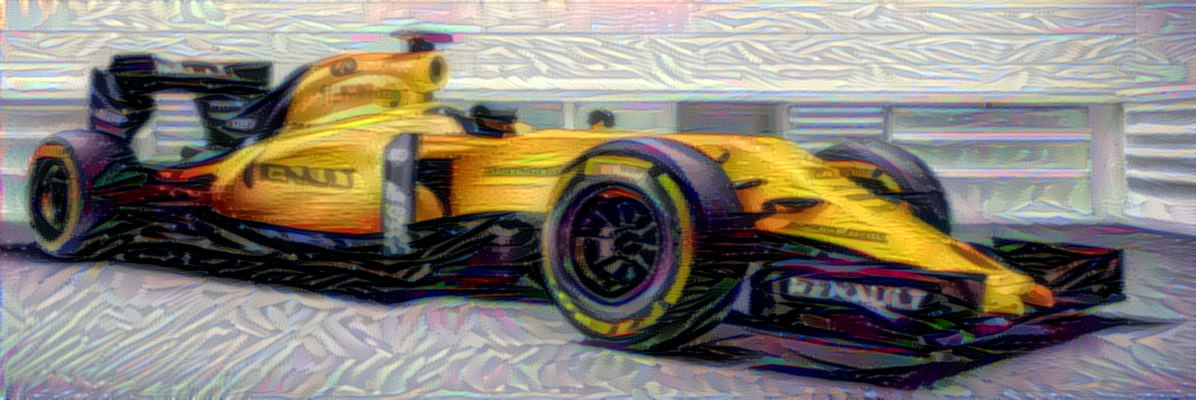

In [17]:
print(fname)
display(Image(fname))